<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Kalman-filter" data-toc-modified-id="The-Kalman-filter-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Kalman filter</a></span><ul class="toc-item"><li><span><a href="#Example-of-aplication:-system-identification" data-toc-modified-id="Example-of-aplication:-system-identification-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example of aplication: system identification</a></span></li><li><span><a href="#Example-of-aplication:-channel-equalization" data-toc-modified-id="Example-of-aplication:-channel-equalization-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example of aplication: channel equalization</a></span></li></ul></li><li><span><a href="#Time-varying-systems" data-toc-modified-id="Time-varying-systems-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time-varying systems</a></span></li></ul></div>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b master https://github.com/edsonportosilva/adaptive-signal-processing
    from os import chdir as cd
    cd('/content/notebooks/')
    ! pip install -e .
    ! pip install SciencePlots

import sympy as sp
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import HTML
from IPython.display import Image
try:
    import scienceplots
except:
    ! pip install SciencePlots
    
from utils import set_preferences, genConvGIF, symdisp, round_expr

plt.style.use(['science','ieee'])
set_preferences()

plt.rcParams['figure.figsize'] = [5, 2.5]
plt.rcParams['figure.dpi'] = 150

saveFigures = False
figurePath = 'G:\\Meu Drive\\DEE UFCG\\Disciplinas e ementas\\TEEE - Processamento adaptativo de sinais\\lecture notes\\figures\\'

In [4]:
from algorithms import estimate_correlation_matrix, estimate_cross_correlation, lms, nlms, lms_newton

# Kalman filter algorithms


## The Kalman filter

In [144]:
#@njit
def kalman_filter(A, H, Q, R, x_init, P_init, y):
    """
    Run a Kalman filter on a series of observations for a system without external inputs.
    
    Parameters:
    - A: State transition matrix.
    - H: Observation matrix.
    - Q: Process noise covariance matrix.
    - R: Measurement noise covariance matrix.
    - x_init: Initial state estimate.
    - P_init: Initial covariance estimate.
    - y: array of observations (measurement vectors).

    Returns:
    - x_estimates: List of state estimates after each observation.
    - P_estimates: List of covariance estimates after each observation.
    """
    # Initialize state and covariance
    x = x_init
    P = x_init*x_init.T
    
    
    try:
        if y.shape[0] > y.shape[1]:
            y = y.T
    except IndexError:
        y = y.reshape(1,len(y))
    
    x_estimates = np.zeros((x_init.shape[0], y.shape[1]))
    
    for ind in range(y.shape[1]):
        y_ = y[:,ind].reshape(-1,1)
        #symdisp('y = ', sp.Matrix(y_))
        
        # Prediction step
        x_pred = A @ x   
        #symdisp('x_{pred} = ', sp.Matrix(x_pred))
        P_pred = A @ P @ A.T + Q     
               
        # Kalman gain
        S = H @ P_pred @ H.T + R                      
        K = P_pred @ H.T @ np.linalg.inv(S)
        #symdisp('K = ', sp.Matrix(K))    
        #symdisp('int1 = ', sp.Matrix((y_ - H @ x_pred)))
        # Update step
        x = x_pred + K @ (y_ - H @ x_pred)
        P = (np.eye(P.shape[0]) - K @ H) @ P_pred
                
        
        #symdisp('int2 = ', sp.Matrix(K@(y[:,ind] - H @ x_pred)))        
        #symdisp('x = ', sp.Matrix(x)) 
        #
        # Store estimates
        x_estimates[:,ind] = x.flatten()

    return x_estimates


In [145]:
import numpy as np

def simulate_mass_spring(dt, total_time, x_init, k, m):
    """
    Simulate an ideal mass-spring system over time using a state-space model.
    
    Parameters:
    - dt: Time step for the simulation.
    - total_time: Total simulation time.
    - x_init: Initial state vector [position, velocity].
    - k: Spring constant.
    - m: Mass of the object.
    
    Returns:
    - positions: Array of positions over time.
    - velocities: Array of velocities over time.
    """
    # Define the state transition matrix for the mass-spring system
    A = np.array([[0, 1],
                  [-k / m, 0]])
    
    # Discretize A for time step dt (using an approximation)
    A_d = np.eye(2) + A * dt
    
    # Initialize state and lists to store the results
    x = np.array(x_init).reshape(-1, 1)
    
    # Number of steps
    num_steps = int(total_time / dt)
    states = np.zeros((x.shape[0], num_steps))
    
    for ind in range(num_steps):
        # Update the state using the discretized state-space model
        x = A_d @ x
        states[:,ind] = x.flatten()
    
    return states, A_d

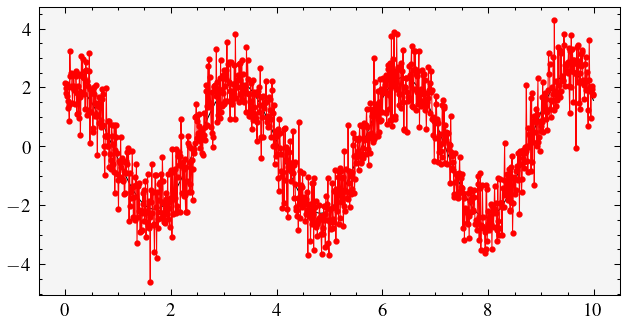

In [146]:
# Define parameters
dt = 0.01              # Time step in seconds
total_time = 10.0      # Total simulation time in seconds
x_init = np.array([[2.0], [1.0]])    # Initial position (1 meter) and initial velocity (0 m/s)
k = 4.0                # Spring constant (N/m)
m = 1.0                # Mass (kg)

# measurement noise
x_var = 0.5
dxdt_var = 0.05

# Simulate the mass-spring system
x, A = simulate_mass_spring(dt, total_time, x_init, k, m)

x_meas = x + np.random.normal(0, np.sqrt(x_var), x.shape[1])
t = np.arange(0, total_time, dt)

plt.plot(t, x[0])
plt.plot(t, x_meas[0],'-o')

#plt.plot(t, dxdt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

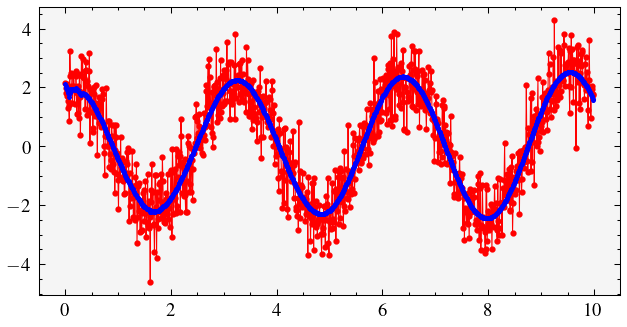

In [148]:

H = np.array([[1, 0]])
symdisp('H =', sp.Matrix(H))

Q = np.zeros((x_init.shape[0],x_init.shape[0]))
symdisp('Q =', sp.Matrix(Q))

P_init = x_init@x_init.T
symdisp('P =', sp.Matrix(P_init))

R = x_var #* np.eye(len(x_init))
#symdisp('R =', sp.Matrix(R))

x_kalman = kalman_filter(A, H, Q, R, x_init, P_init, x_meas[0,:])

plt.plot(t, x[0])
plt.plot(t, x_meas[0],'-o')
plt.plot(t, x_kalman[0,:],'-*')

### Example of aplication: system identification

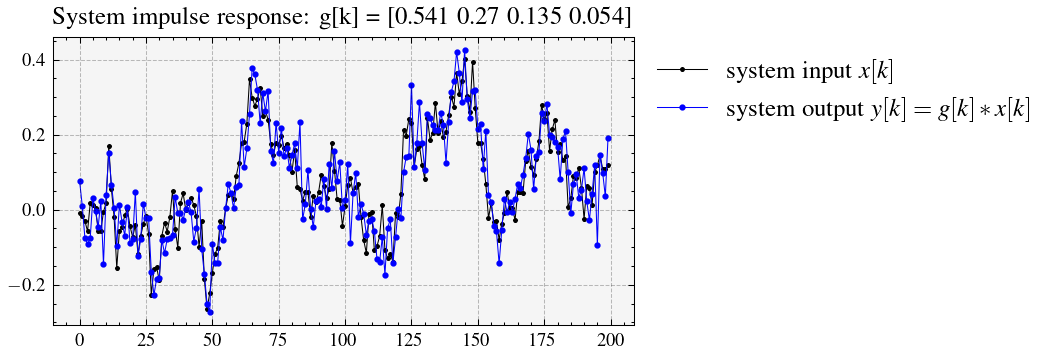

In [83]:
nsamples = 100000
σ2 = 0.0025 # noise variance

# Define input signal to the system
#x = 2*np.random.randint(0, 2, nsamples)-1
x = np.convolve(np.random.normal(0, 0.8, nsamples), np.ones(16)/16,'same')
#x = np.random.normal(0, 1, nsamples)

# Define impulse response of the system
g = np.array([1, 0.5, 0.25, 0.1])
g = g/np.sum(g)

# Convolve input signal with system's impulse response
y = np.convolve(x, g,'same')
y = np.roll(y, 1) # remove input-output delay

# Generate noise and add noise to the systens output
n = np.random.normal(0, np.sqrt(σ2), nsamples)
y += n

plt.plot(x[0:200],'-*k', label='system input $x[k]$')
plt.plot(y[0:200],'-ob', label='system output $y[k] = g[k]\\ast x[k]$');
plt.title(f'System impulse response: g[k] = {g.round(3)}');
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

In [26]:
# Estimate correlation matrix R = E[x*x.T]
R = estimate_correlation_matrix(x, 4)

symdisp('\\boldsymbol{R}_{xx} = ', sp.Matrix(R), numDig=3)

<IPython.core.display.Math object>

In [27]:
# Calculate eigenvalues and eigenvectors associated to R
eigenvalues, eigenvectors = np.linalg.eig(R)

Λ = sp.Matrix(np.diag(eigenvalues))
Q = sp.Matrix(eigenvectors)

print('Matrix of eigenvalues of R:')
symdisp('\\boldsymbol{Λ} = ', Λ, numDig=3)
#symdisp('\\boldsymbol{Q} = ', Q, numDig=3)
#symdisp('\\boldsymbol{R} = \\boldsymbol{Q}\\boldsymbol{Λ}\\boldsymbol{Q}^T = ', Q*Λ*Q.T, numDig=3)

Matrix of eigenvalues of R:


<IPython.core.display.Math object>

In [28]:
# Estimate cross correlation matrix R = E[d*x]
p = estimate_cross_correlation(x, y, 4)

symdisp('\\boldsymbol{p}_{yx} = ', sp.Matrix(p), numDig=3)

h_opt = np.linalg.inv(R)@p
mmse_sys_id = np.mean(y**2) - (h_opt.T)@p

print('Impulse response of the system:')
symdisp('\\boldsymbol{g} = ', sp.Matrix(g), numDig=3)
print('Estimated impulse response of the system :')
symdisp('\\boldsymbol{h}_{opt} =  \\boldsymbol{R}_{xx}^{-1}\\boldsymbol{p}_{yx} =', sp.Matrix(h_opt), numDig=3)
symdisp('\\mathrm{MMSE} = \\mathbb{E}[y^2] - \\boldsymbol{h}_{opt}^{T}\\boldsymbol{p}_{yx} =', sp.Matrix([mmse_sys_id])[0], numDig=3)

<IPython.core.display.Math object>

Impulse response of the system:


<IPython.core.display.Math object>

Estimated impulse response of the system :


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
# Calculate estimated system output:
y_hat = np.convolve(x, h_opt, 'same')
y_hat = np.roll(y_hat, 1)

mse_estimated = np.mean((y-y_hat)**2)

print('Time averaged MSE:')
symdisp('\\mathrm{MSE} = \\frac{1}{M}\\sum_{i=1}^{M} (y[i]-\\hat{y}[i])^2 =',sp.Matrix([mse_estimated])[0], numDig=3)

Time averaged MSE:


<IPython.core.display.Math object>

In [30]:
μ = 1e-3
λ = 0.99
Ntaps = 4

out_lms, h, squaredError_lms, H = lms(x, y, Ntaps, μ)
out_rls, h, squaredError_rls, H = rls(x, y, Ntaps, λ)

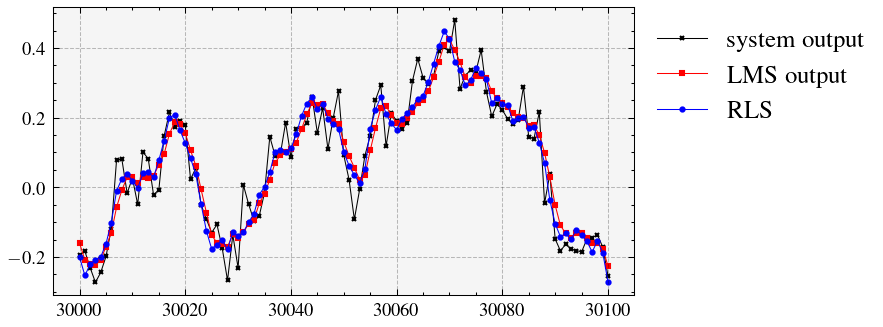

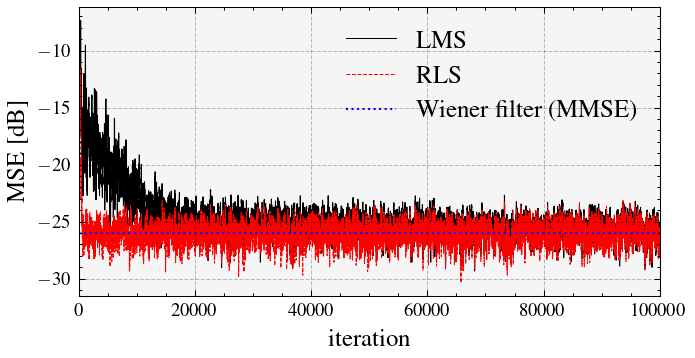

In [31]:
start = 30000
ind = np.arange(start,start+101)

plt.figure()
plt.plot(ind,y[ind],'-xk', label='system output')
plt.plot(ind,out_lms[ind],'-sr', label='LMS output')
plt.plot(ind,out_rls[ind],'-ob', label='RLS')
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

average_window_len = 50
mse_lms_dB = 10*np.log10(np.convolve(squaredError_lms,np.ones(average_window_len)/average_window_len, 'same'))
mse_rls_dB = 10*np.log10(np.convolve(squaredError_rls,np.ones(average_window_len)/average_window_len, 'same'))

plt.figure()
plt.plot(mse_lms_dB, label='LMS')
plt.plot(mse_rls_dB, label='RLS')
plt.plot(10*np.log10(mmse_sys_id)*np.ones(len(mse_lms_dB)), linewidth=1, label=' Wiener filter (MMSE)')
plt.xlim(0,len(mse_lms_dB))
plt.xlabel('iteration')
plt.ylabel('$\\mathrm{MSE}$ [dB]')
plt.legend()
plt.grid();

### Example of aplication: channel equalization

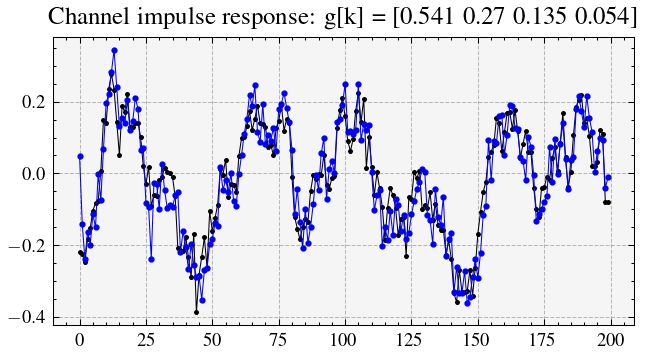

In [32]:
nsamples = 100000
σ2 = 0.0025 # noise variance

# Define input signal to the system
# x = 2*np.random.randint(0, 2, nsamples)-1
x = np.convolve(np.random.normal(0, 0.8, nsamples), np.ones(16)/16,'same')
#x = np.random.normal(0, 1, nsamples)

# Define impulse response of the system
g = np.array([1, 0.5, 0.25, 0.1])
g = g/np.sum(g)

# Convolve input signal with system's impulse response
y = np.convolve(x, g,'same')
y = np.roll(y, 1) # remove input-output delay

# Generate noise and add noise to the systens output
n = np.random.normal(0, np.sqrt(σ2), nsamples)
y += n

plt.plot(x[0:200],'-*k', label='system input')
plt.plot(y[0:200],'-ob', label='system output');
plt.title(f'Channel impulse response: g[k] = {g.round(3)}');

plt.grid()

In [33]:
# Estimate correlation matrix R = E[y*y.T]
R = estimate_correlation_matrix(y, 4)

symdisp('\\boldsymbol{R}_{yy} = ', sp.Matrix(R), numDig=3)

# Calculate eigenvalues and eigenvectors associated to R
eigenvalues, eigenvectors = np.linalg.eig(R)

Λ = sp.Matrix(np.diag(eigenvalues))
Q = sp.Matrix(eigenvectors)

print('Matrix of eigenvalues of R:')
symdisp('\\boldsymbol{Λ} = ', Λ, numDig=3)
# symdisp('\\boldsymbol{Q} = ', Q, numDig=3)
# symdisp('\\boldsymbol{R} = \\boldsymbol{Q}\\boldsymbol{Λ}\\boldsymbol{Q}^T = ', Q*Λ*Q.T, numDig=3)

<IPython.core.display.Math object>

Matrix of eigenvalues of R:


<IPython.core.display.Math object>

In [34]:
# Estimate cross correlation matrix R = E[x*y]
p = estimate_cross_correlation(y, x, 4)

h_opt = np.linalg.inv(R)@p
mmse_ch_eq = np.mean(x**2) - (h_opt.T)@p

print('Impulse response of the channel:')
symdisp('\\boldsymbol{g} = ', sp.Matrix(g), numDig=3)
print('Estimated optimal channel equalizer filter coefficients (Wiener filter):')
symdisp('\\boldsymbol{h}_{opt} =  \\boldsymbol{R}_{yy}^{-1}\\boldsymbol{p}_{xy} =', sp.Matrix(h_opt), numDig=3)
symdisp('\\mathrm{MMSE} = \\mathbb{E}[x^2] - \\boldsymbol{h}_{opt}^{T}\\boldsymbol{p}_{xy} =', sp.Matrix([mmse_ch_eq])[0], numDig=3)

Impulse response of the channel:


<IPython.core.display.Math object>

Estimated optimal channel equalizer filter coefficients (Wiener filter):


<IPython.core.display.Math object>

<IPython.core.display.Math object>

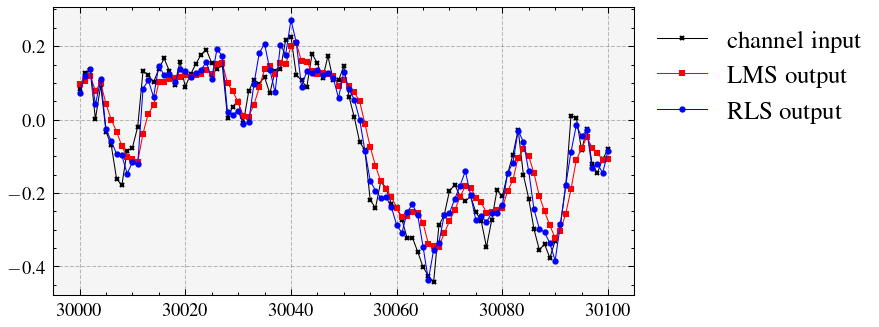

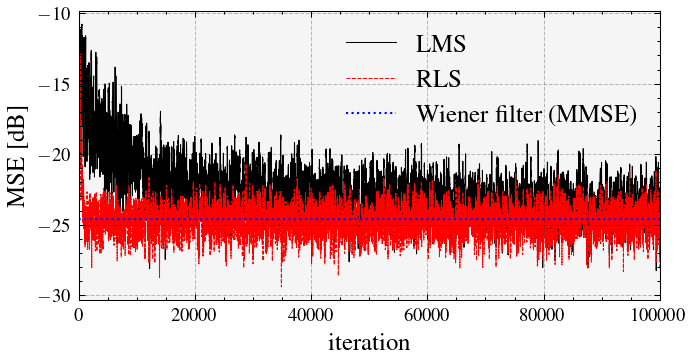

In [35]:
μ = 1e-3
λ = 0.99
Ntaps = 4

# Run LMS and LMS-Newton
out_lms, h, squaredError_lms, H = lms(y, x, Ntaps, μ)
out_rls, h, squaredError_rls, H = rls(y, x, Ntaps, λ)

start = 30000
ind = np.arange(start,start+101)

# Compare results:
plt.figure()
plt.plot(ind, x[ind],'-xk', label='channel input')
plt.plot(ind,out_lms[ind],'-sr', label='LMS output')
plt.plot(ind,out_rls[ind],'-ob', label='RLS output')
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

average_window_len = 50
mse_lms_dB = 10*np.log10(np.convolve(squaredError_lms,np.ones(average_window_len)/average_window_len, 'same'))
mse_rls_dB = 10*np.log10(np.convolve(squaredError_rls,np.ones(average_window_len)/average_window_len, 'same'))

plt.figure()
plt.plot(mse_lms_dB, label=' LMS')
plt.plot(mse_rls_dB, label='RLS')
plt.plot(10*np.log10(mmse_ch_eq)*np.ones(len(mse_lms_dB)), linewidth=1, label='Wiener filter (MMSE)')
plt.xlim(0,len(mse_lms_dB))
plt.xlabel('iteration')
plt.ylabel('$\\mathrm{MSE}$ [dB]')
plt.legend(bbox_to_anchor=(1, 1));
#plt.xlim(0,20000)
plt.grid();

## Time-varying systems

In [36]:
from algorithms import time_varying_filter
from utils import random_square_signal

In [51]:
σ2 = 0.00025 # noise variance
Ntaps = 4
H = np.zeros((len(x), Ntaps))

fh = 100
fs = 500000
timeIdx = np.arange(len(x))*(1/fs)

H[:,0] = 1
H[:,1] = 0.75 + 0.25*np.sin(2*np.pi*fh*timeIdx + np.pi/67)
H[:,2] = 0.25 + 0.125*np.cos(2*np.pi*fh*timeIdx + np.pi/13)
H[:,3] = 0.05 + 0.05*np.sin(2*np.pi*fh*timeIdx + np.pi/77)


# Time-varying system
y = time_varying_filter(x, H)

# Generate noise and add noise to the systens output
n = np.random.normal(0, np.sqrt(σ2), len(y))
y += n

# Parameters to run LMS, NLMS, LMS-Newton and RLS
μ = 5e-3
α = 2*μ 
Ntaps = 4
λ = 0.99

out_lms, h, squaredError_lms, H_lms = lms(x, y, Ntaps, μ)
out_lms_newton, h, squaredError_lms_newton, H_lms_newton = lms_newton(x, y, Ntaps, μ, α)
out_nlms, h, squaredError_nlms, H_nlms = nlms(x, y, Ntaps, μ)
out_rls, h, squaredError_rls, H_rls = rls(x, y, Ntaps, λ)

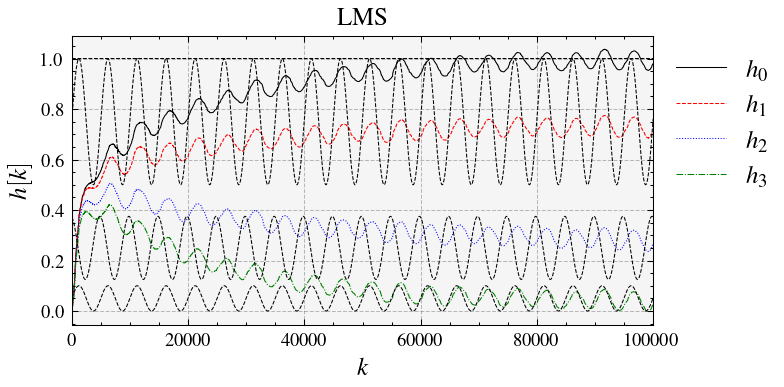

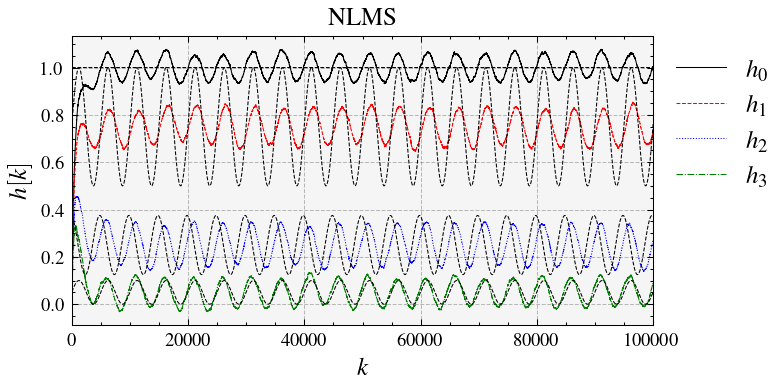

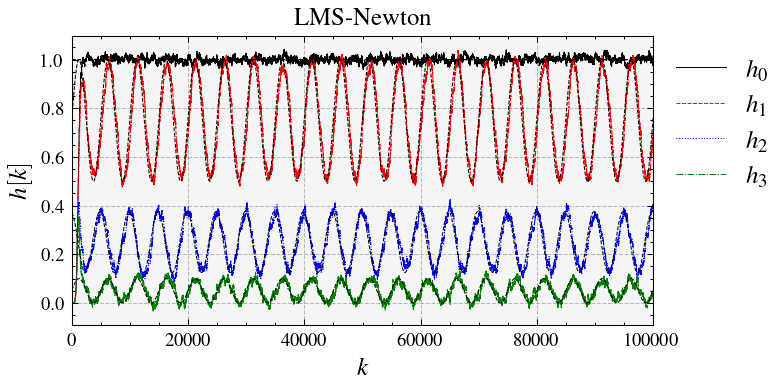

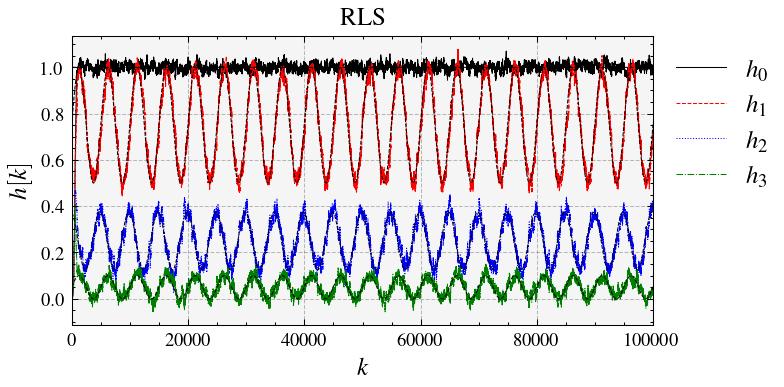

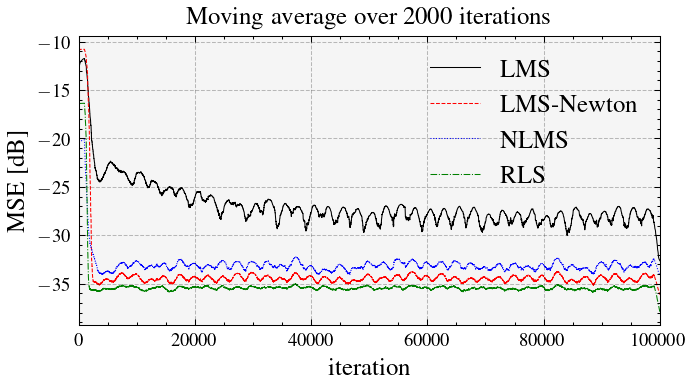

In [52]:
plt.figure()
for k in range(Ntaps):
    plt.plot(H_lms[:,k],label = f'$h_{k}$')
    
for k in range(Ntaps):
    plt.plot(H[:,k],'--k', linewidth=0.5)
    
plt.xlabel('$k$')
plt.ylabel('$\\boldsymbol{h}[k]$')
plt.title('LMS')
plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
plt.grid();
plt.xlim(0,H.shape[0])

plt.figure()
for k in range(Ntaps):
    plt.plot(H_nlms[:,k],label = f'$h_{k}$')

for k in range(Ntaps):
    plt.plot(H[:,k],'--k', linewidth=0.5)
    
plt.xlabel('$k$')
plt.ylabel('$\\boldsymbol{h}[k]$')
plt.title('NLMS')
plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
plt.grid();
plt.xlim(0,H.shape[0])

plt.figure()
for k in range(Ntaps):
    plt.plot(H_lms_newton[:,k],label = f'$h_{k}$')

for k in range(Ntaps):
    plt.plot(H[:,k],'--k', linewidth=0.5)
    
plt.xlabel('$k$')
plt.ylabel('$\\boldsymbol{h}[k]$')
plt.title('LMS-Newton')
plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
plt.grid();
plt.xlim(0,H.shape[0])

plt.figure()
for k in range(Ntaps):
    plt.plot(H_rls[:,k],label = f'$h_{k}$')

for k in range(Ntaps):
    plt.plot(H[:,k],'--k', linewidth=0.5)
    
plt.xlabel('$k$')
plt.ylabel('$\\boldsymbol{h}[k]$')
plt.title('RLS')
plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
plt.grid();
plt.xlim(0,H.shape[0])


average_window_len = 2000
mse_lms_dB = 10*np.log10(np.convolve(squaredError_lms,np.ones(average_window_len)/average_window_len, 'same'))
mse_lms_newton_dB = 10*np.log10(np.convolve(squaredError_lms_newton,np.ones(average_window_len)/average_window_len, 'same'))
mse_nlms_dB = 10*np.log10(np.convolve(squaredError_nlms,np.ones(average_window_len)/average_window_len, 'same'))
mse_rls_dB = 10*np.log10(np.convolve(squaredError_rls,np.ones(average_window_len)/average_window_len, 'same'))

plt.figure()
plt.title(f'Moving average over {average_window_len} iterations')
plt.plot(mse_lms_dB, label=' LMS')
plt.plot(mse_lms_newton_dB, label='LMS-Newton')
plt.plot(mse_nlms_dB, label='NLMS')
plt.plot(mse_rls_dB, label='RLS')
plt.xlim(0,len(mse_lms_dB))
plt.xlabel('iteration')
plt.ylabel('$\\mathrm{MSE}$ [dB]')
plt.legend(bbox_to_anchor=(1, 1));
#plt.xlim(0,20000)
plt.grid();